# 1) Introduction: Computational Geometry and scipy.spatial

In [49]:
import scipy
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
scipy.__version__

'0.19.0'

# 2) Distances between arrays of points

## 2.1) scipy.spatial.distance_matrix

### 2.1.1) Euclidean (L2 norm)

There are many cases where it is desirable to calculate the distances between all possible pairs of points from two data sets. Consider a self-driving vehicle that is programmed to avoid animals that enter a roadway. It may have a set of coordinates that represent the vehicle proper relative to some kind of camera / detector, and another set of coordinates that represent the apparent obstruction (animal on the road).

For simplicity, lets define the two sets of coordinates randomly:

In [8]:
vehicle_coords = np.random.random((50,3))
animal_coords = np.random.random((600,3))

In order to calculate the amount of time that the vehicle has to make a course adjustment, it would be sensible to first calculate the closest distance between a point on the vehicle and a point on the animal. Lets try this by calculating all possible distances between the objects and finding the minimum of that distance matrix.

In [11]:
from scipy.spatial import distance_matrix
all_distances = distance_matrix(vehicle_coords, animal_coords)
all_distances.shape

(50, 600)

Each row of the distance matrix represents a point on the vehicle, and each column (value in a given row) is the distance between that point on the vehicle and one of the points on the animal (ordered by index).

In [13]:
closest_distance = all_distances.min()
closest_distance

0.028003950663311409

### 2.1.2) Rectilinear (L1 norm)

Consider another situation, where a self-driving vehicle is aware (i.e., via real-time 'traffic' reporting) of an animal obstructing a roadway, even though the vehicle does not have line of sight to the animal obstacle. The animal is a few city blocks away, but the vehicle would still benefit from a distance & time estimate so that appropriate adjustments may be made. 

In this case, the straight-line Euclidean distance would not represent the shortest distance the vehicle would travel in practice--instead, we need to consider the so-called L1 norm / taxicab geometry/ Manhattan distance, etc. 

In [16]:
taxicab_distances = distance_matrix(vehicle_coords, animal_coords, p=1)
taxicab_distances.shape

(50, 600)

In [17]:
closest_taxicab_distance = taxicab_distances.min()
closest_taxicab_distance

0.039965928608402312

## 2.2) scipy.spatial.distance.cdist

### 2.2.1) Faster than distance_matrix for Euclidean norm

In [18]:
%timeit distance_matrix(vehicle_coords, animal_coords)

1000 loops, best of 3: 1.64 ms per loop


In [19]:
from scipy.spatial.distance import cdist

In [20]:
%timeit cdist(vehicle_coords, animal_coords)

1000 loops, best of 3: 358 µs per loop


In [28]:
# confirm same value for p=2 norm
distance_matrix(vehicle_coords, animal_coords, p=2).min() == cdist(vehicle_coords, animal_coords, metric='euclidean').min()

True

### 2.2.2) Faster than distance_matrix for L1 norm

In [29]:
%timeit distance_matrix(vehicle_coords, animal_coords, p=1)

1000 loops, best of 3: 1.4 ms per loop


Slower with minkowski metric specification though!

In [33]:
%timeit cdist(vehicle_coords, animal_coords, metric='minkowski', p=1)

100 loops, best of 3: 5.23 ms per loop


Use cityblock metric instead of p=1 minkowski

In [34]:
# time equivalent calculation using alternative calling convention
%timeit cdist(vehicle_coords, animal_coords, metric='cityblock')

10000 loops, best of 3: 166 µs per loop


Make sure the two different rectilinear calling conventions produce the same value

In [36]:
cdist(vehicle_coords, animal_coords, metric='minkowski', p=1).min() == cdist(vehicle_coords, animal_coords, metric='cityblock').min()

True

And likewise for cdist vs. distance_matrix for rectilinear distance

In [31]:
# confirm same value for p=1 norm
distance_matrix(vehicle_coords, animal_coords, p=1).min() == cdist(vehicle_coords, animal_coords, metric='minkowski', p=1).min()

True

### 2.2.3) Using cdist for Mahalanobis distance -- clustering and outlier detection

Apart from the enhanced performance (at least for the data shapes tested above) of `cdist` over `distance_matrix`, `cdist` also has access to a wide variety of distance metrics with a plethora of possible applications.

Consider the following ellipsoidal and circular data sets:

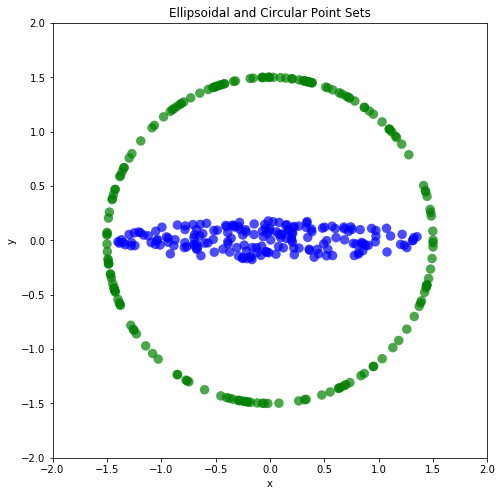

In [92]:
# ellipsoidal point set generation: http://stackoverflow.com/a/5529199/2942522
np.random.seed(255792)
width = 2.82
height = 0.36
phi = np.random.random((180)) * 2 * math.pi 
rho = np.random.random((180))
x_ellipse = np.sqrt(rho) * np.cos(phi)
y_ellipse = np.sqrt(rho) * np.sin(phi)
x_ellipse *= width / 2.0
y_ellipse *= height / 2.0
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_ellipse, y_ellipse, c='blue', alpha=0.7, edgecolor='none', s=90)
ax.set_title('Ellipsoidal and Circular Point Sets')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
circle_radius = 1.5
x_circle = np.cos(phi) * circle_radius
y_circle = np.sin(phi) * circle_radius
ax.scatter(x_circle, y_circle, c='green', alpha=0.7, edgecolor='none', s=90)

fig.set_size_inches(8,8)

The Mahalanobis distance for each circular point (relative to the elliptical point set) will account for the "shape" of the ellipse and not just the mean of the elliptical points.



In [108]:
np.dstack((x_ellipse, y_ellipse))[0].shape

(180, 2)

In [111]:
mahalanobis_distances = cdist(np.dstack((x_ellipse, y_ellipse))[0],
                              np.dstack((x_circle, y_circle))[0],
                              metric='mahalanobis')
mahalanobis_distances.shape

(180, 180)

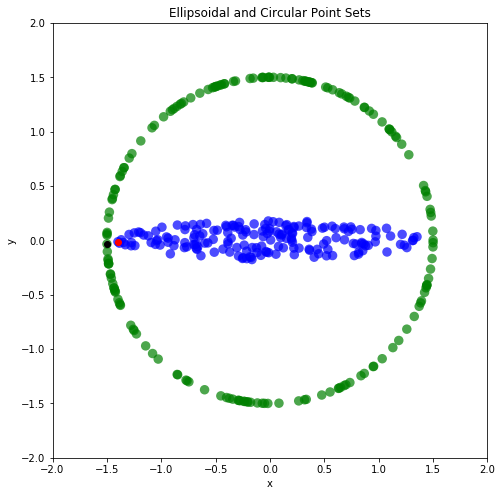

In [122]:
ellipse_index, circle_index = np.where(mahalanobis_distances == mahalanobis_distances.min())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_ellipse, y_ellipse, c='blue', alpha=0.7, edgecolor='none', s=90)
ax.set_title('Ellipsoidal and Circular Point Sets')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.scatter(x_circle, y_circle, c='green', alpha=0.7, edgecolor='none', s=90)
ax.scatter(x_ellipse[ellipse_index], y_ellipse[ellipse_index], c = 'red')
ax.scatter(x_circle[circle_index], y_circle[circle_index], c = 'k')
fig.set_size_inches(8,8)

## 2.3) scipy.spatial.distance.pdist

In [123]:
from scipy.spatial.distance import pdist

### 2.3.1) pdist basics -- very simple example

In [133]:
test_array = np.array([[0,0],
                       [0,1],
                       [0,2]])

The *condensed* distance matrix returned by `pdist` for the above `test_array` should have three values:

1. Distance between [0,0] and [0,1]
2. Distance between [0,0] and [0,2]
3. Distance between [0,1] and [0,2]

Let's try it:

In [134]:
condensed_matrix = pdist(test_array)
condensed_matrix

array([ 1.,  2.,  1.])

Although it may be relatively easy to track which distance value corresponds to which pair of points in this case, if `test_array` were much larger, working with a condensed distance matrix may become confusing.

This is where `scipy.spatial.distance.squareform` becomes useful:

In [135]:
from scipy.spatial.distance import squareform
redundant_matrix = squareform(condensed_matrix)
redundant_matrix

array([[ 0.,  1.,  2.],
       [ 1.,  0.,  1.],
       [ 2.,  1.,  0.]])

Even though `pdist` does not calculate the distance between a point and *itself*, `squareform` converts the condensed distance matrix to the familiar redundant form that would also be returned by `cdist` for the data set compared with *itself*:

In [136]:
cdist(test_array, test_array)

array([[ 0.,  1.,  2.],
       [ 1.,  0.,  1.],
       [ 2.,  1.,  0.]])

It is worth noting that `squareform` can perform the reverse conversion as well:

In [138]:
squareform(cdist(test_array, test_array)) # produce the same result as pdist by using squareform

array([ 1.,  2.,  1.])




| <font color='blue'>Development Note</font>| Type of Change | Pull Request # | `scipy` Implementation Version |
|----------------|------------|----------|
| `squareform` no longer converts all input data to `float64` | <font color='green'>Enhancement</font> | 6457 | <font color='purple'>0.19</font> |


